# 训练逻辑回归(LR)模型，进行医学文本分类

## 1. 获得训练数据，测试数据

In [20]:
import codecs
import numpy as np
import pandas as pd
import jieba
import pickle
import time
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [21]:
# 导入数据
# 这是训练数据
train_file = "../data/train.data" 
train_data = pd.read_csv(train_file, sep="\t", header=None, names=["id", "category", "sentence"])

# 这是测试数据
test_file = "../data/test.data" 
test_data = pd.read_csv(test_file, sep="\t", header=None, names=["id", "sentence"])
print("训练集数据有：{}条".format(len(train_data)))
print("测试集数据有：{}条".format(len(test_data)))

训练集数据有：8000条
测试集数据有：2000条


In [22]:
# 展示前10条训练数据
train_data.head(10)

,id,category,sentence
0,s1,Diagnostic,(2)若伴便秘者符合罗马Ⅳ功能性便秘诊断标准，若伴夜尿症者符合夜尿症的诊断标准；
1,s2,Therapy or Surgery,（1）患者拟行急症手术；
2,s3,Enrollment in other studies,c) 在过去6个月内参加过I、II期临床试验或者3个月内参加过III、IV期临床试验；
3,s4,Risk Assessment,4. 身高體重指數(BMI)&gt;=25得病人
4,s5,Consent,5.愿意参与该研究并配合调查者；
5,s6,Organ or Tissue Status,（3）术前合并严重肝肾功能不全者；
6,s7,Laboratory Examinations,ii.筛选访视时在血清HBV DNA≥107copies/mL
7,s8,Age,3，绝经后患者。
8,s9,Consent,⑥患者及家属知情同意并签署知情同意书。
9,s10,Laboratory Examinations,(17)血红蛋白低于90g/L；


In [23]:
# 查看训练数据的类别，及其数目
train_data.groupby(['category'],  as_index=False)['category'].agg({'count': 'count'})

,category,count
0,Addictive Behavior,196
1,Age,638
2,Allergy Intolerance,430
3,Compliance with Protocol,294
4,Consent,874
5,Diagnostic,794
6,Disease,1177
7,Enrollment in other studies,358
8,Laboratory Examinations,755
9,Life Expectancy,101


In [24]:
# 展示前10条测试数据
test_data.head(10)

,id,sentence
0,s1,1.符合脓毒症诊断Sepsis 3.0版标准；
1,s2,1）符合WHO对不孕症的诊断标准；
2,s3,3. 肿瘤直径 ≥8mm且≤30mm;
3,s4,8.合并其他运动可能加重的神经、肌肉、骨骼肌、风湿性疾病；
4,s5,2. 符合国际疾病分类（ICD-10）编码 J21 的毛细支气管炎诊断标准。
5,s6,4.ECOG PS：0-1分；
6,s7,4.对造影剂、局麻药等过敏者；
7,s8,6. 同时参加其他临床研究
8,s9,⑥过敏体质者；
9,s10,3.受试者同意参加本试验，并签署知情同意书。


## 2. 数据格式转换

### 2.1 把文本转换为向量，使用TF-IDF算法

In [25]:
# 将文本转换为向量
def tfidf(raw_text):
    #将中文文本分词，并以空格隔开，使用jieba分词工具。
    import jieba
    preprocess_setences = []
    sentences =raw_text
    for sentence in sentences:
        words = [word for word in jieba.cut(sentence)]
        preprocess_setences.append(' '.join(words))

    # 使用sklearn自带的CoutVectorizer模块即可简单生成特征向量
    from sklearn.externals import joblib
    from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
    
    # 词向量的维度设定为1000，可根据情况设定，少则文本信息不足，多则增加训练时间
    counter = CountVectorizer(max_features=200)  
    counts = counter.fit_transform(preprocess_setences)
    print('countvectorizer词表:\n',counter.vocabulary_)  
    
    # 将词汇表输出到文件
    with open("LR_count_voca", "w") as f:  
        for word, freq in counter.vocabulary_.items():
            f.write("{}\t{}\n".format(word, freq))
    # print('词向量矩阵:\n',counts.toarray())  #fit_transform后查看具体向量
    
    tfidfer = TfidfTransformer()
    tfidf = tfidfer.fit_transform(counts)
    print('tfidf向量矩阵：\n',tfidf.toarray())  #fit_transform后查看具体向量矩阵
    joblib.dump(counter, 'LR_count_vect') #保存矢量化
    return list(tfidf.toarray())

train_text = list(train_data['sentence'])
result = tfidf(train_text)
# 将转化后的向量保存在data_X中
data_X = [np.array(i) for i in result]

countvectorizer词表:
 {'符合': 147, '诊断': 178, '标准': 121, '患者': 96, '手术': 103, '过去': 183, '参加': 65, 'ii': 27, '临床试验': 39, '或者': 102, 'bmi': 21, 'gt': 25, '病人': 134, '愿意': 99, '参与': 64, '研究': 142, '配合': 188, '合并': 69, '严重': 35, '肝肾': 161, '功能': 58, '筛选': 148, '血清': 172, 'ml': 29, '家属': 80, '知情': 141, '同意': 70, '签署': 149, '同意书': 71, '年龄': 84, '50': 12, '80': 17, '药物滥用': 169, '史者': 68, '急性': 92, '依从性': 49, '治疗': 128, '大于': 75, '不能': 34, '接受': 107, '长期': 191, '激素': 129, '明确': 116, '18': 7, '受试者': 66, '自愿': 166, '10': 0, '切除': 57, '试验': 179, '开始': 86, '30': 10, '天内': 76, '酗酒': 190, '存在': 78, '酒精': 189, '药物': 168, '同时': 72, '其他': 52, '恶性肿瘤': 93, '疾病': 133, '正在': 125, '使用': 48, '术前': 119, '凝血': 55, '时间': 114, '正常值': 127, '上限': 32, '以下': 43, '65': 14, '以上': 42, '病史': 136, '可能': 67, '影响': 89, '根据': 122, '需要': 195, '70': 15, '书面': 41, '术后': 120, '病理': 137, '检查': 123, '确诊': 144, '原发性': 62, '既往': 113, '放疗': 110, '检测': 124, '阳性': 192, '组前': 156, '周内': 73, '服用': 117, '任何': 45, '包括': 60, '糖尿病': 154, '高血压

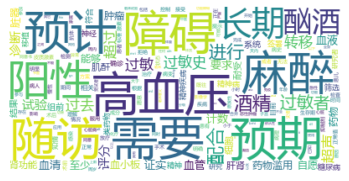

In [26]:
# 词云显示所选的组成词向量的词
import matplotlib.pyplot as plt
from wordcloud import WordCloud
cloud_words = []
with open("LR_count_voca", "r") as f:
    for line in f:
        l = line.strip().split("\t")
        cloud_words.extend([l[0]] * int(l[1]))
wordcloud_ = WordCloud(background_color="white", collocations=False, max_words=1000, font_path="C:\\Windows\\Fonts\\msyh.ttc").generate(" ".join(cloud_words))

plt.figure()
plt.imshow(wordcloud_, interpolation='bilinear')
plt.axis("off")
plt.show()


### 2.1 将类别(15个)转换为数字(0-14)表示

In [27]:
# 将raw_category的15个类别转换为0-14的数字
raw_category = list(train_data['category'])
category_ = sorted(list(set(list(train_data['category']))))
category_index = {}
for i in category_:
    category_index[i] = category_.index(i)
    print(category_.index(i), i)
data_Y = np.array([category_index[c] for c in raw_category])

0 Addictive Behavior
1 Age
2 Allergy Intolerance
3 Compliance with Protocol
4 Consent
5 Diagnostic
6 Disease
7 Enrollment in other studies
8 Laboratory Examinations
9 Life Expectancy
10 Organ or Tissue Status
11 Pharmaceutical Substance or Drug
12 Risk Assessment
13 Smoking Status
14 Therapy or Surgery


### 2.3 查看转换后的训练数据的输入与输出格式

In [28]:
print(data_X[1]) #应为太大，8000条数据，只显示第一行查看一下
print(data_Y) # 所有的类别，8000条

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.56974827 0.         0.         0.         0.         

## 3. 训练逻辑回归模型

### 3.1 使用训练数据训练，并保存模型

In [29]:
from sklearn.linear_model import LogisticRegression
import pickle
import time

# 训练
start_time = time.time()
model = LogisticRegression(penalty='l2')
model.fit(data_X, data_Y)
print('training took %fs!' % (time.time() - start_time))

# 保存模型
model_save_file = "LR.mkl"
pickle.dump(model, open(model_save_file, 'wb'))

training took 0.173535s!


C:\Users\310272293\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\310272293\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## 4. 如何预测新输入？

### 4.1 构建预测函数

In [30]:
import jieba
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
tags = ("Addictive Behavior", "Age", "Allergy Intolerance", "Compliance with Protocol", "Consent", "Diagnostic", "Disease", "Enrollment in other studies", "Laboratory Examinations", "Life Expectancy", "Organ or Tissue Status", "Pharmaceutical Substance or Drug", "Risk Assessment", "Smoking Status", "Therapy or Surgery")
def predict(sentence):
    # 利用之前的词汇构建特征向量
    words = [word for word in jieba.cut(sentence)]
    preprocess_s = ' '.join(words)

    # 导入tf-idf词表
    count_vect = joblib.load('LR_count_vect')
    tfidfer = TfidfTransformer()
    X_new_counts = count_vect.transform([preprocess_s])
    tfidf = tfidfer.fit_transform(X_new_counts)
    criteria_X = tfidf.toarray()

    # 使用之前训练的参数，进行预测
    predict_inputs = model.predict(criteria_X)
    predict_results = tags[predict_inputs[0]]
    return predict_results

### 4.2 输入一条句子，进行预测

In [31]:
# 输入一条新句子
# s = "3.有糖尿病的患者。"
# s = "1.术后发生非计划再次手术；"
s = "白细胞计数升高或大于10^9/L"
predict(s)

'Laboratory Examinations'

### 4.3 输入一份文件，进行预测，并保存结果

In [32]:
# 预测测试集数据的结果，并保存为文件test.predict
import codecs
test_sentences = list(test_data["sentence"])
n = 0
with codecs.open("../data/test.LR.predict", "w", encoding="utf-8") as f:
    for s in test_sentences:
        n += 1
        c = predict(s) # 预测
        f.write("s{}\t{}\t{}\n".format(n,c,s)) # 保存
        # 显示进度
        if n%10 ==0: print("[INFO] Processing: {0}/{1} \t {2:<50s} {3:10s}".format(str(n), str(len(test_sentences)), c, s))

[INFO] Processing: 10/2000 	 Consent                                            3.受试者同意参加本试验，并签署知情同意书。
[INFO] Processing: 20/2000 	 Consent                                            1.了解试验全过程，自愿参加并签署知情同意书；
[INFO] Processing: 30/2000 	 Therapy or Surgery                                 4.近期手术史   
[INFO] Processing: 40/2000 	 Diagnostic                                         1）符合MCI诊断标准
[INFO] Processing: 50/2000 	 Disease                                            （8）病情未得到控制的高血压患者；
[INFO] Processing: 60/2000 	 Age                                                1、年龄≥18岁； 
[INFO] Processing: 70/2000 	 Consent                                            5.自愿签署知情同意书。
[INFO] Processing: 80/2000 	 Disease                                            1.肝细胞肝癌根治性切除术后患者；
[INFO] Processing: 90/2000 	 Disease                                            6.存在胃食管反流及误吸风险（胃食管反流疾病一周超过一次）
[INFO] Processing: 100/2000 	 Laboratory Examinations                            c)白细胞计数升高或大于10^9/L
[INFO] Processing: 1

[INFO] Processing: 810/2000 	 Diagnostic                                         （2）GH和IGF-1水平符合内分泌诊断标准；
[INFO] Processing: 820/2000 	 Consent                                            2.签署知情同意书。
[INFO] Processing: 830/2000 	 Disease                                            7.患有胰腺癌、膀胱癌等恶性肿瘤患者；
[INFO] Processing: 840/2000 	 Disease                                            ① 既往有脑卒中、脑肿瘤、脑外伤及其他神经精神系统病史；
[INFO] Processing: 850/2000 	 Addictive Behavior                                 3、有吸毒或药物滥用史者。
[INFO] Processing: 860/2000 	 Pharmaceutical Substance or Drug                   7.接受药物成瘾或酒精中毒治疗或具有药物成瘾或酒精中毒病史的患者；
[INFO] Processing: 870/2000 	 Therapy or Surgery                                 4) 盆腔手术病史；
[INFO] Processing: 880/2000 	 Therapy or Surgery                                 ⑷美罗培南连续用药时间超过2天；
[INFO] Processing: 890/2000 	 Consent                                            9．受试者必须理解并签署知情同意书。
[INFO] Processing: 900/2000 	 Age                                                6. 年龄&gt;90

[INFO] Processing: 1590/2000 	 Laboratory Examinations                            (7)目前免疫抑制治療（超過40毫克的糖皮質激素，每天或硫唑嘌呤）
[INFO] Processing: 1600/2000 	 Disease                                            8.精神、神经障碍，不能正确表达意愿及沟通障碍者；
[INFO] Processing: 1610/2000 	 Diagnostic                                         2.股骨干的定义：根据OTA定义，股骨干是指近端位于股骨小转子下水平以远，远端股骨髁间宽度为边长的正方形区域以近的部分。
[INFO] Processing: 1620/2000 	 Diagnostic                                         2）病理学或临床检查确诊为肝细胞癌患者；
[INFO] Processing: 1630/2000 	 Therapy or Surgery                                 （4）预计患者存活时间小于48小时
[INFO] Processing: 1640/2000 	 Age                                                ⑸满18周岁。   
[INFO] Processing: 1650/2000 	 Consent                                            1．在执行任何研究方案规定的程序之前，完全解释本研究的性质并且必须取得受试者的知情同意。如受试者没有能力表达意见，可由受试者的法定代理人签署书面知情同意；
[INFO] Processing: 1660/2000 	 Risk Assessment                                    （3）睡眠严重程度量表（Insomnia Severity Index, ISI）评分≥11分；
[INFO] Processing: 1670/2000 	 Laboratory Exam

### 4.4 系统评估

In [33]:
import sys
sys.path.append("../code")
import evaluation
results = evaluation.Record_results('../data/test.gold', '../data/test.LR.predict')
evaluation = evaluation.Evaluation(results.records)

**************************************** Evaluation Results ****************************************
                                       Precision.       Recall.          f1.            
                 Addictive Behavior    0.9762           0.8200           0.8913         
                                Age    0.9868           0.9434           0.9646         
                Allergy Intolerance    0.9537           0.9537           0.9537         
           Compliance with Protocol    0.8750           0.7568           0.8116         
                            Consent    0.9860           0.9680           0.9770         
                         Diagnostic    0.8462           0.8333           0.8397         
                            Disease    0.6230           0.8095           0.7041         
        Enrollment in other studies    0.9239           0.9444           0.9341         
            Laboratory Examinations    0.8156           0.7766           0.7956         
         